# <center> <font color='blue'> PROJETO: Prevendo o Nível de Satisfação dos Clientes do Santander

![title](imagens/projeto.png)

<justify> Neste projeto iremos utilizar dados dos clientes do santander para avaliar o nível de satisfação dos mesmos, tais informações serão de grande utilizade para avaliação de campanhas capazes de aumentar o nível de satisfação de clientes insatisfeitos e manter a alta satisfação dos demais. O principal desafio a nossa frente é apresentar um modelo com acurácia superior a 70% para identificar clientes insatisfeitos.

## <center> <font color='blue'> FERRAMENTAS  

In [395]:
#Importando as bibliotecas a serem utilizadas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay  
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings

In [371]:
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 14})

In [441]:
def plot_multiple_CM(modelo, X_treino, X_teste, y_treino, y_teste):
    
    #realiza as previsões:
    previsoes_treino = modelo.predict(X_treino)
    previsoes_teste = modelo.predict(X_teste)
    
    #calcula a matriz de confusão:
    CM_treino = confusion_matrix(y_treino, previsoes_treino) #normalize='pred'
    CM_teste = confusion_matrix(y_teste, previsoes_teste) #normalize='pred'
    
    #projeta a figura:
    fig, ax = plt.subplots(1,2, figsize=(15,10))
    ax[0].set_title("TREINO")
    ax[1].set_title("TESTE")

    ConfusionMatrixDisplay(
    confusion_matrix = CM_treino, 
    display_labels = ['Satisfeito', 'Insatisfeito']).plot(ax=ax[0], colorbar=False, cmap='magma')


    ConfusionMatrixDisplay(
    confusion_matrix = CM_teste, 
    display_labels = ['Satisfeito', 'Insatisfeito']).plot(ax=ax[1], colorbar=False, cmap='magma')

    plt.subplots_adjust(wspace=0.40, hspace=0.1); 

In [446]:
def sobreamostragem(modelo, X_treino, X_teste, y_treino, y_teste):

    #syntetic minority oversample tecnique
    smote = SMOTE()
    X_smote, y_smote = smote.fit_resample(X_treino, y_treino)


    modelo.fit(X_smote, y_smote)


    smote_pred = random_smote.predict(X_smote)
    cm = confusion_matrix(y_smote, smote_pred, normalize='true')

    plot_multiple_CM(random_smote, X_smote, X_teste, y_smote, y_teste);

## <center> <font color='blue'> ANÁLISE EXPLORATÓRIA DOS DADOS

In [2]:
#Carregando os dados
#iremos carregar os dados em um df para realizar análise exploratória

df = pd.read_csv("datasets/train.csv")

In [3]:
#O dataset é constituido por 371 variáveis preditoras e 76020 observações

df.shape

(76020, 371)

In [4]:
#Cinco primeiras observações

df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


<justify>O dataset apresenta um elevado número de variváveis (370), o que pode ser levemente problemático...

In [5]:
#A variável ID presente no dataset não apresenta nenhuma informação relevante para a análise de satsfação, dito isto 
#iremos excluir
df = df.iloc[:,1:]
df.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [6]:
df.describe()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,8237.820000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [7]:
#Distribuição da variável alvo
df["TARGET"].value_counts().sort_index()

0    73012
1     3008
Name: TARGET, dtype: int64

A variável alvo em nosso estudo encontra se extremamente desbalanceada

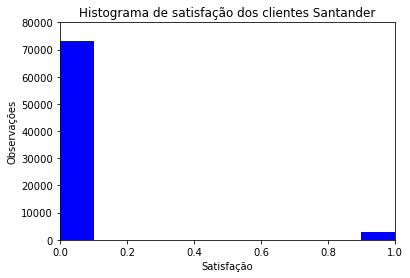

In [8]:
#Graficamente
plt.hist(df["TARGET"], facecolor='b', alpha=1)

plt.xlabel('Satisfação')
plt.ylabel('Observações')
plt.title('Histograma de satisfação dos clientes Santander')
plt.xlim(0, 1)
plt.ylim(0, 80000)
plt.grid(False)
plt.show()

O nível de satisfação é representado pelos valores numéricos 0 e 1, onde 0 representa os clientes satisfeitos e 1 os clientes insatisfeitos com os serviços do Santander.

In [9]:
X = df.iloc[:,0:271]
y = pd.DataFrame(df["TARGET"])

Iremos separar os dados entre treino e teste para assim balancearmos as classes alvo no dataset de treino através do SMOTE (Synthetic Minority Oversampling Technique) e evitarmos problemas posteriores.

In [94]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in split.split(X, y):
    X_treino, X_teste = X.loc[train_index], X.loc[test_index]
    y_treino, y_teste = y.loc[train_index], y.loc[test_index]

In [449]:
#escalonando as variáveis de treino

escalonador = StandardScaler()
X_treino_esc = escalonador.fit_transform(X_treino)

In [ ]:
abc = 123

## <center> <font color='blue'> TRABALHANDO A QUESTÃO DA DIMENSIONALIDADE

In [71]:
#Iremos utilizar um número de variáveis que explique 99% da variância de nosso dataset

pca_99 = PCA(n_components=0.99)
pca_treino_99 = pca_99.fit_transform(X_treino)
pca_teste_99 = pca_99.fit_transform(X_teste)


In [72]:
exp_var_pca_99 = pca_99.explained_variance_ratio_
cum_sum_eigenvalues_99 = np.cumsum(exp_var_pca_99)

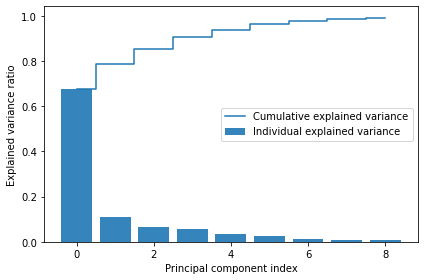

In [73]:
plt.bar(range(0,len(exp_var_pca_99)), exp_var_pca_99, alpha=0.9, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues_99)), cum_sum_eigenvalues_99, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Como demonstrado no gráfico acima, uma redução de dimensionalidade de 270 para 6 nos permite explicar 95% da variância do dataset. Tais medidas nos ajuda a poupar poder computacional e gerar modelos mais "enxutos". 

In [87]:
#Variáveis preditores com dimensionalidade reduzida, explicando 99% da variãncia
X_treino = pd.DataFrame(pca_treino_99)
X_teste = pd.DataFrame(pca_teste_99)

## <center> <font color='blue'> TREINANDO OS MODELOS BASE

In [408]:
random_forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42)
random_forest.fit(X_treino, np.ravel(y_treino));

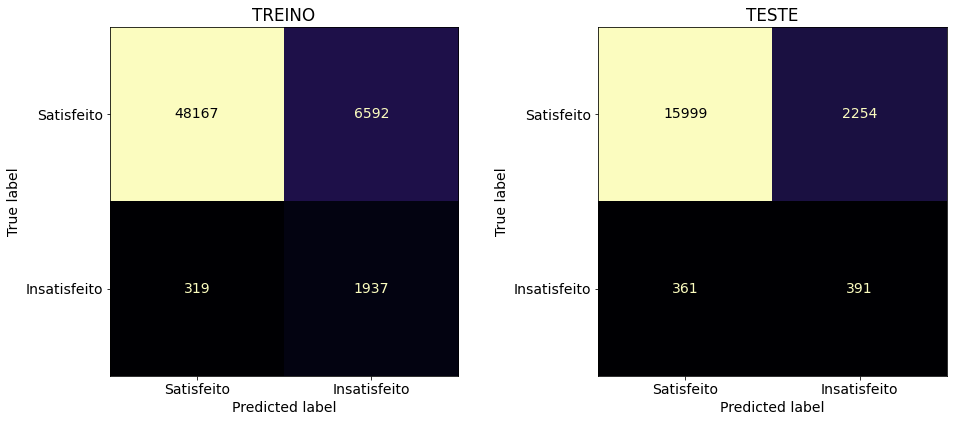

In [443]:
plot_multiple_CM(random_forest, X_treino, X_teste, y_treino, y_teste)

In [411]:
confusion_matrix(y_treino, y_pred)

array([[48167,  6592],
       [  319,  1937]], dtype=int64)

In [410]:
y_pred = random_forest.predict(X_treino)
print(classification_report(y_treino, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     54759
           1       0.23      0.86      0.36      2256

    accuracy                           0.88     57015
   macro avg       0.61      0.87      0.65     57015
weighted avg       0.96      0.88      0.91     57015



In [ ]:
def area_sob_curva(modelo, X, y):
    y_score = random_forest.predict_proba(y)[:,1]
    falsos_positivos_rate, verdadeiros_positivos_rate, threshold1 = roc_curve(y, y_score)

In [390]:
y_score = random_forest.predict_proba(X_teste)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_teste, y_score)
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_teste, y_score))

roc_auc_score for DecisionTree:  0.7527892529470528


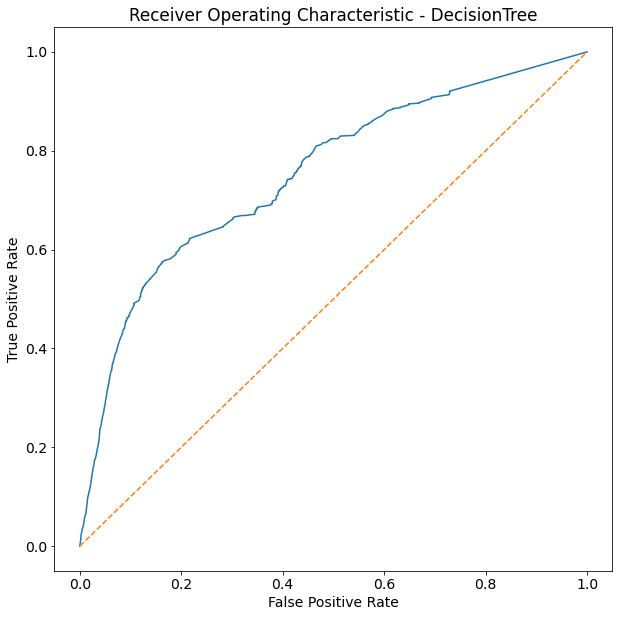

In [389]:
plt.subplots(figsize=(10,10))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## <center> <font color='blue'> TREINANDO MODELO XGBOOST

In [259]:
xgb_base = xgb.XGBClassifier(use_label_encoder=False, scale_pos_weight=24, random_state=42,
                               eval_metric='auc') 


In [ ]:
xgb_base.fit(X_treino,np.ravel(y_treino))

In [267]:
params={'learning_rate' : [0.25,0.30,0.35], 'max_depth' : [4, 6, 8, 10],
 'min_child_weight' : [ 1, 3, 5],
 'gamma': [ 0.0, 0.3, 0.5 ],
 'colsample_bytree' : [0.5, 0.7, 0.9],
 'eval_metric': ['auc']
}

grid_search_xgb = GridSearchCV(classifier,param_grid=params,scoring='roc_auc',n_jobs=-1,cv=3,verbose=1)

In [268]:
grid_search_xgb.fit(X_treino,np.ravel(y_treino))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: 

In [250]:
grid_search_xgb.cv_results_

{'mean_fit_time': array([35.81697663, 85.5655938 , 92.16339246, 83.04681269, 66.2774512 ]),
 'std_fit_time': array([1.10623865, 2.57377545, 6.15187302, 9.26773321, 0.78117134]),
 'mean_score_time': array([0.12497211, 0.21349208, 0.16142106, 0.1822501 , 0.1405921 ]),
 'std_score_time': array([2.33601546e-06, 1.94825738e-02, 3.20988326e-02, 2.65502240e-02,
        2.55096781e-02]),
 'param_min_child_weight': masked_array(data=[7, 7, 3, 7, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[6, 10, 10, 10, 8],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.25, 0.15, 0.2, 0.3, 0.25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.0, 0.5, 0.0, 0.5, 0.5],
              mask=[False, False, False,